# Previsão do desempenho (nota geral) do candidato
- Neste notebook, será realizada uma tarefa de regressão, que consiste na previsão da nota geral do candidato (target) com base nas variáveis que vimos na análise exploratória de dados. Será aplicado o aprendizado supervisionado, com um conjunto de dados rotulado e um target contínuo.
- O objetivo consiste em construir um modelo de machine learning capaz de prever acuradamente a nota geral do candidato. Além disso, avaliar quais variáveis independentes impactam mais e menos a nota.
- Para isso, técnicas de limpeza e pré-processamento de dados (feature engineering), treinamento (seleção de features, comparação com validação cruzada, seleção, tunagem de hiperparâmetros) e validação de modelos de machine learning (avaliação de métricas em conjunto de testes) serão aplicadas.
- Todo esse processo será baseado no framework CRISP-DM, podendo envolver ciclos de pré-processamento e validação de modelos repetidamente.
- Pipeline de modelagem:
    - Divisão dos dados em treino, teste e validação.
    - Limpeza e pré-processamento dos dados.
    - Comparação e seleção de modelo potencial com validação cruzada k-fold.
    - Seleção de features.
    - Tunagem de hiperparâmetros.
    - Avaliação final no conjunto de testes (simulando o ambiente de produção).
    - Deploy.

#### 1. Importando as bibliotecas

In [2]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import time
import optuna
import os
import pickle
from src.modelling_utils import *

# Definições de cores -> todas estão numa escala de mais escura para mais clara.
CINZA1, CINZA2, CINZA3 = '#231F20', '#414040', '#555655'
CINZA4, CINZA5, CINZA6 = '#646369', '#76787B', '#828282'
CINZA7, CINZA8, CINZA9 = '#929497', '#A6A6A5', '#BFBEBE'
AZUL1, AZUL2, AZUL3, AZUL4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
VERMELHO1, VERMELHO2, VERMELHO3, VERMELHO4, VERMELHO5 = '#DB0527', '#E23652', '#ED8293', '#F4B4BE', '#FBE6E9'
VERDE1, VERDE2 = '#0C8040', '#9ABB59'
LARANJA1 = '#F79747'
AMARELO1, AMARELO2, AMARELO3, AMARELO4, AMARELO5 = '#FFC700', '#FFCC19', '#FFEB51', '#FFE37F', '#FFEEB2'
BRANCO = '#FFFFFF'

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

#### 2. Coletando os dados
- Considerando que estamos tentando prever o desempenho do candidato na prova, serão incluídos na modelagem apenas dados de estudantes que compareceram em ambos os dias de prova, como visto na Análise de Desempenho no notebook '2_eda.ipynb'. Dessa forma, evitamos distorções e assimetrias, afinal, alunos que não comparecem ficam com nota nula.

In [3]:
# Reading the memory optimized data.
path = 'D:\\MLProjects\\DadosENEM\\clean_df.parquet'
df = pd.read_parquet(path)

# Selecting only students who were present in both the days of the exam.
df = df.loc[(df['presenca_lc'] == 'Presente') & (df['presenca_ch'] == 'Presente') 
            & (df['presenca_cn'] == 'Presente') & (df['presenca_mt'] == 'Presente')].reset_index(drop=True)

#### 2.1 Rápida visualização e informações gerais

In [21]:
df.head()

,faixa_etaria,sexo,estado_civil,status_conclusao_ensino_medio,escola,treineiro,municipio_prova,uf_prova,presenca_cn,presenca_ch,...,nota_comp3,nota_comp4,nota_comp5,nota_redacao,escolaridade_pai,escolaridade_mae,renda_familiar_mensal,possui_celular_em_casa,possui_computador_em_casa,acesso_internet_em_casa
0,Jovem adulto (18-24),F,Solteiro(a),Concluído,Não respondeu,Não,Presidente Tancredo Neves,BA,Presente,Presente,...,120.0,140.0,160.0,760.0,Ensino médio completo,Ensino superior completo,"Até R$ 1.212,00",Dois ou mais,Não,Sim
1,Jovem adulto (18-24),M,Solteiro(a),Concluído,Não respondeu,Não,Cariacica,ES,Presente,Presente,...,40.0,100.0,20.0,320.0,Ensino fundamental incompleto,Nunca estudou,Nenhuma Renda,Dois ou mais,Um,Sim
2,Jovem adulto (18-24),F,Solteiro(a),Concluído,Não respondeu,Não,São Gonçalo,RJ,Presente,Presente,...,80.0,100.0,40.0,440.0,Ensino médio completo,Ensino médio completo,"Até R$ 1.212,00",Dois ou mais,Não,Sim
3,Jovem adulto (18-24),F,Solteiro(a),Concluído,Não respondeu,Não,Arcoverde,PE,Presente,Presente,...,80.0,80.0,40.0,360.0,Ensino médio completo,Ensino médio completo,"Até R$ 1.212,00",Um,Não,Sim
4,Adolescente (< 18),F,Solteiro(a),Último ano,Privada,Não,Nossa Senhora da Glória,SE,Presente,Presente,...,180.0,200.0,200.0,940.0,Ensino médio completo,Ensino médio completo,"Até R$ 1.212,00",Dois ou mais,Não,Sim


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344823 entries, 0 to 2344822
Data columns (total 29 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   faixa_etaria                   category
 1   sexo                           category
 2   estado_civil                   category
 3   status_conclusao_ensino_medio  category
 4   escola                         category
 5   treineiro                      category
 6   municipio_prova                object  
 7   uf_prova                       category
 8   presenca_cn                    category
 9   presenca_ch                    category
 10  presenca_lc                    category
 11  presenca_mt                    category
 12  nota_cn                        float32 
 13  nota_ch                        float32 
 14  nota_lc                        float32 
 15  nota_mt                        float32 
 16  lingua                         category
 17  nota_comp1                 

In [23]:
print(f'O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.')

O dataset possui 2344823 linhas e 29 colunas.


#### 2.2 Valores nulos e duplicados
- Valores nulos e duplicados, tipos de dados, entre outros processos já foram tratados no notebook '1_data_cleaning.ipynb'. Além disso, muitas variáveis irrelevantes já foram removidas. Iremos realizar daqui para frente, um refinamento com propósitos de modelagem, afinal, a limpeza inicial foi feita direcionada à análise exploratória de dados.

In [24]:
df.isna().sum()

faixa_etaria                     0
sexo                             0
estado_civil                     0
status_conclusao_ensino_medio    0
escola                           0
treineiro                        0
municipio_prova                  0
uf_prova                         0
presenca_cn                      0
presenca_ch                      0
presenca_lc                      0
presenca_mt                      0
nota_cn                          0
nota_ch                          0
nota_lc                          0
nota_mt                          0
lingua                           0
nota_comp1                       0
nota_comp2                       0
nota_comp3                       0
nota_comp4                       0
nota_comp5                       0
nota_redacao                     0
escolaridade_pai                 0
escolaridade_mae                 0
renda_familiar_mensal            0
possui_celular_em_casa           0
possui_computador_em_casa        0
acesso_internet_em_c

#### 2.3 Variáveis numéricas e categóricas
- Irei verificar as variáveis numéricas e categóricas.
- Isso influenciará a escolha de encoders e scalers futuramente na etapa de pré-processamento de dados. Cardinalidade é um fator importante a ser considerado.
- Algumas variáveis podem ser transformadas de início. Por exemplo, variáveis binárias podem ter seus valores mapeados a 1 e 0.
- Essas transformações antes do split não configuram data leakage pois são realizadas linha a linha.
- Algumas variáveis podem ser removidas de início.

In [27]:
categorical_features = df.select_dtypes(['category', 'object']).columns.to_list()
numerical_features = df.select_dtypes('number').columns.to_list()
print(f'Há {len(categorical_features)} variáveis categóricas. São elas: {categorical_features}')
print(f'Há {len(numerical_features)} variáveis numéricas. São elas: {numerical_features}')

Há 19 variáveis categóricas. São elas: ['faixa_etaria', 'sexo', 'estado_civil', 'status_conclusao_ensino_medio', 'escola', 'treineiro', 'municipio_prova', 'uf_prova', 'presenca_cn', 'presenca_ch', 'presenca_lc', 'presenca_mt', 'lingua', 'escolaridade_pai', 'escolaridade_mae', 'renda_familiar_mensal', 'possui_celular_em_casa', 'possui_computador_em_casa', 'acesso_internet_em_casa']
Há 10 variáveis numéricas. São elas: ['nota_cn', 'nota_ch', 'nota_lc', 'nota_mt', 'nota_comp1', 'nota_comp2', 'nota_comp3', 'nota_comp4', 'nota_comp5', 'nota_redacao']


In [26]:
print('Cardinalidade das variáveis categóricas: ')
for feature in categorical_features:
    print(f'{feature} ({df[feature].nunique()})', end=', ')

Cardinalidade das variáveis categóricas: 
faixa_etaria (7), sexo (2), estado_civil (5), status_conclusao_ensino_medio (4), escola (3), treineiro (2), municipio_prova (1712), uf_prova (27), presenca_cn (1), presenca_ch (1), presenca_lc (1), presenca_mt (1), lingua (2), escolaridade_pai (7), escolaridade_mae (7), renda_familiar_mensal (10), possui_celular_em_casa (3), possui_computador_em_casa (3), acesso_internet_em_casa (2), 

In [27]:
print('Domínios das variáveis categóricas: ')
print()
for feature in categorical_features:
    print(f'{feature} ({df[feature].value_counts(normalize=True) * 100})')
    print()

Domínios das variáveis categóricas: 

faixa_etaria (faixa_etaria
Jovem adulto (18-24)            53.912897
Adolescente (< 18)              35.137066
Adulto jovem (25-35)             7.054605
Adulto de meia idade (36-45)     2.485774
Meia idade (46-55)               1.051167
Pré aposentadoria (56-65)        0.308723
Idoso (> 66)                     0.049769
Name: proportion, dtype: float64)

sexo (sexo
F    61.269785
M    38.730215
Name: proportion, dtype: float64)

estado_civil (estado_civil
Solteiro(a)                  92.323173
Casado(a)/União Estável       3.337182
Não informado                 3.115928
Divorciado(a)/Separado(a)     1.145971
Viúvo(a)                      0.077746
Name: proportion, dtype: float64)

status_conclusao_ensino_medio (status_conclusao_ensino_medio
Concluído        41.074273
Último ano       40.844490
Cursando         17.786844
Não concluído     0.294393
Name: proportion, dtype: float64)

escola (escola
Não respondeu    59.155510
Pública          32.448206


- Possuem característica ordinal as variáveis: faixa_etaria, status_conclusao_ensino_medio, escolaridade_pai, escolaridade_mae, renda_familiar_mensal, possui_celular_em_casa e possui_computador_em_casa.
- A variávei municipio_prova possui altíssima cardinalidade (1712 domínios distintos), não sendo relevante para a análise. Portanto, será removida.
- Variáveis representando a presença ou ausência do candidato serão removidas, afinal, estamos lidando apenas com candidatos presentes e estas não só serão irrelevantes para a modelagem, bem como possuem variância constante.
- Variáveis contendo a nota do candidato nas diferentes áreas do conhecimento, redação ou competências da redação serão removidas a fim de evitar data leakage. Não sabemos qual a nota do candidato em nada no ambiente de produção, isso é justamente o que queremos prever. Incluí-las criaria um cenário irreal, superestimando a performance do modelo.
- A variável escola será removida pois possui 60% de nulos. Esses nulos representam alunos que não responderam qual o tipo de escola em que estudavam, por ser um campo opcional.
- A variável estado civil será removida pois possui uma variância quase constante. Ela está altamente desbalanceada, com mais de 92% das observações pertencendo à categoria 'Solteiro(a)'. Além disso, mais de 3% estão como 'Não informado', constituindo valores nulos, dado que esse campo era opcional.
- Serão removidas observações de estudantes que obtiveram nota 0, considerando a sua baixíssima frequência e considerando que estamos supondo que, uma vez presente, o aluno realizará a prova conforme é previsto. Ademais, isso permitirá que calculemos métricas como o MAPE.
- A variável uf_prova também possui alta cardinalidade e será condensada em uma nova variável chamada "região". Essa nova variável manterá a informação e permitirá melhor aproveitamento pelo modelo, reduzindo a cardinalidade.
- O nosso target será a nota geral, isto é, média das 5 provas (Linguagens, Ciências Humanas, Ciências da Natureza, Matemática e Redação). Iremos criar essa variável.
- Serão mapeadas para binário ou ordinal as variáveis: acesso_internet_em_casa, possui_computador_em_casa, possui_celular_em_casa, lingua e treineiro.
- Nas variáveis representando a escolaridade do pai e da mãe, há uma categoria "Não sei", indicando valores nulos. Esse valor nulo se deve provavelmente por esse ser um campo opcional do questionário socioeconômico, fazendo com que alguns estudantes pulem ele. Dito isso, podemos imputá-los ou removê-los. Eu irei imputá-los com o valor mais frequente, uma vez que esse domínio representa uma parte considerável dos nossos dados.
- Variáveis como acesso_internet_em_casa e possui_celular_em_casa estão bastante desbalanceadas e serão avalidas na etapa de feature selection. Apesar de estarem desbalanceadas, foi visto na eda que elas apresentam distinção entre distribuições de notas obtidas pelos alunos. Talvez sejam importantes. 
- Considerando o significado geral parecido (responsável possui ensino superior), proporções parecidas, e pequena diferença de nota geral média observada na eda, irei combinar as categorias 'Ensino superior completo' e 'Pós-graduação' nas variáveis escolaridade_pai e escolaridade_mae. Isso poderá ajudar o modelo pois, claramente há uma distinção nas notas daqueles cujos pais graduaram-se.
- Dadas as baixíssimas proporções e diferença mínima de nota geral média observada na eda, irei unir as categorias Pré aposentadoria (56-65) e Idoso (> 66), Adulto de meia idade (36-45) e Meia idade (46-55) na variável faixa_etaria. Isso reduz a cardinalidade e também poderá ajudar o modelo a não se confundir. O mesmo vale para as categorias Acima de R$ 24.240,00 e R$ 18.180,01 - R$ 24.240,00 na variável renda_familiar_mensal. O mesmo vale para a variável renda_familiar_mensal, que terá categorias combinadas a fim de reduzir o número de domínios distintos.
- Estou combinando de forma mais conservadora dado que vi diferenças nas distribuições das notas mesmo para categorias de baixa proporção. Entretanto, serão testadas mais combinações no futuro.

#### 2.4 Limpeza de dados
- Efetuarei os tópicos levantados acima.

In [4]:
# Creating a copy of the dataframe to procceed for data cleaning and next steps.
clean_df = df.copy()

- Feature engineering.

In [5]:
# Creating a feature indicating the students' average grade.
clean_df['nota_geral'] = (clean_df['nota_lc'] + clean_df['nota_ch'] + clean_df['nota_cn'] + clean_df['nota_mt'] + clean_df['nota_redacao']) / 5

# Creating a feature indicating the region where the students' exams were applied.
def define_regions(x):
    if x in set(['RS', 'SC', 'PR']):
        return 'Sul'
    elif x in set(['SP', 'RJ', 'MG', 'ES']):
        return 'Sudeste'
    elif x in set(['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']):
        return 'Nordeste'
    elif x in set(['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO']):
        return 'Norte'
    else:
        return 'Centro-Oeste'

clean_df['regiao'] = clean_df['uf_prova'].apply(define_regions)

- Removendo observações com nota geral zero.

In [134]:
len(clean_df.loc[clean_df['nota_geral'] == 0])

22

In [6]:
clean_df = clean_df.loc[~(clean_df['nota_geral'] == 0)]
clean_df.shape

(2344801, 32)

- Mapeamento para binário 1/0 e ordinal 2/1/0.

In [7]:
# Mapping to binary or ordinal.
clean_df['sexo'] = clean_df['sexo'].replace(to_replace={'M': 1, 'F': 0}).astype('int32')
clean_df['lingua'] = clean_df['lingua'].replace(to_replace={'Inglês': 1, 'Espanhol': 0}).astype('int32')
clean_df['treineiro'] = clean_df['treineiro'].replace(to_replace={'Sim': 1, 'Não': 0}).astype('int32')
clean_df['acesso_internet_em_casa'] = clean_df['acesso_internet_em_casa'].replace(to_replace={'Sim': 1, 'Não': 0}).astype('int32')
clean_df['possui_celular_em_casa'] = clean_df['possui_celular_em_casa'].replace(to_replace={'Dois ou mais': 2, 'Um': 1, 'Não': 0}).astype('int32')
clean_df['possui_computador_em_casa'] = clean_df['possui_computador_em_casa'].replace(to_replace={'Dois ou mais': 2, 'Um': 1, 'Não': 0}).astype('int32')

- Dropando variáveis.

In [8]:
# Dropping irrelevant columns.
to_drop = ['municipio_prova', 'presenca_cn', 'presenca_ch', 
       'presenca_lc', 'presenca_mt', 'nota_cn', 'nota_ch',
       'nota_lc', 'nota_mt', 'nota_comp1', 'nota_comp2',
       'nota_comp3', 'nota_comp4', 'nota_comp5', 'nota_redacao', 
       'escola', 'estado_civil', 'uf_prova']

clean_df = clean_df.drop(columns=to_drop)
clean_df.shape

(2344801, 14)

In [9]:
# Assessing which are the remaining columns.
clean_df.columns.tolist()

['faixa_etaria',
 'sexo',
 'status_conclusao_ensino_medio',
 'treineiro',
 'lingua',
 'escolaridade_pai',
 'escolaridade_mae',
 'numero_pessoas_em_casa',
 'renda_familiar_mensal',
 'possui_celular_em_casa',
 'possui_computador_em_casa',
 'acesso_internet_em_casa',
 'nota_geral',
 'regiao']

- Combinando categorias.

In [10]:
# Combining similar educational level categories.
clean_df['escolaridade_mae'] = clean_df['escolaridade_mae'].replace(to_replace={'Pós-graduação': 'Ensino superior completo'})
clean_df['escolaridade_pai'] = clean_df['escolaridade_pai'].replace(to_replace={'Pós-graduação': 'Ensino superior completo'})

# Combining similar low proportion income categories.
clean_df['renda_familiar_mensal'] = clean_df['renda_familiar_mensal'].replace(to_replace={
    'Até R$ 1.212,00': 'Renda baixa',
    'R$ 1.212,01 - R$ 1.818,00': 'Renda baixa',
    'R$ 1.818,01 - R$ 3.030,00': 'Renda média baixa',
    'R$ 3.030,01 - R$ 4.848,00': 'Renda média baixa',
    'R$ 4.848,01 - R$ 7.272,00': 'Renda média alta',
    'R$ 7.272,01 - R$ 10.908,00': 'Renda média alta', 
    'R$ 10.908,01 - R$ 18.180,00': 'Renda alta',
    'R$ 18.180,01 - R$ 24.240,00': 'Renda alta',
    'Acima de R$ 24.240,00': 'Renda alta'
})

# Combining similar low proportion age categories.
clean_df['faixa_etaria'] = clean_df['faixa_etaria'].replace(to_replace={'Adulto de meia idade (36-45)': 'Adulto a meia idade (36-55)',
                                                            'Meia idade (46-55)': 'Adulto a meia idade (36-55)',
                                                            'Pré aposentadoria (56-65)': 'Pré aposentadoria a idoso (> 56)',
                                                            'Idoso (> 66)': 'Pré aposentadoria a idoso (> 56)'})

#### 3. Split dos dados em sets de treino, teste e validação
- Os dados de teste são dados que o modelo nunca viu. Por isso, irei realizar o split antes de qualquer coisa. O teste será isolado e utilizado apenas no final para avaliar uma vez o melhor modelo escolhido. Isso garantirá uma avaliação de performance confiável, simulando um ambiente real de produção. Ademais, data leakage também é evitado, aplicando apenas 'transform' neste conjunto.
- Os dados de validação serão utilizados na tunagem de hiperparâmetros para avaliar o modelo treinado em cada configuração. Isso nos ajuda a prevenir o overfitting, evitando decisões baseadas em ajuste excessivo ao conjunto de treinamento.

In [11]:
# Obtaining predictor and target sets.
X = clean_df.drop(columns=['nota_geral'])
y = clean_df['nota_geral'].copy()

# Setting 80% training, 10% test and 10% validation.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train predictor set shape: {X_train.shape}. Train target set shape: {y_train.shape}')
print(f'Test predictor set shape: {X_test.shape}. Test target set shape: {y_test.shape}')
print(f'Validation predictor set shape: {X_val.shape}. Validation target set shape: {y_val.shape}')

Train predictor set shape: (1875840, 13). Train target set shape: (1875840,)
Test predictor set shape: (234480, 13). Test target set shape: (234480,)
Validation predictor set shape: (234481, 13). Validation target set shape: (234481,)


#### 4. Pré-processamento dos dados
- Para treinar modelos de machine learning, é necessário aplicar algumas transformações aos dados:
    - Imputar valores nulos: Há alguns valores nulos nas variáveis escolaridade_pai e escolaridade_mae, representados pela categoria 'Não sei'. Considerando que na escolaridade_pai estes representam uma parcela de 8% dos dados (alta), iremos imputá-los com a moda, e não removê-los.
    - Outliers: Não há outliers.
    - Para algoritmos baseados em árvore, não é necessário feature scaling. Entretanto, uma vez que eu desejo testar diferentes modelos, aplicarei feature scaling nas variáveis categóricas após sua codificação (não há variáveis numéricas). Assim será possível comparar todos os modelos de uma vez.
    - Variáveis numéricas: Alguns algoritmos são sensíveis ao escalonamento de características, pois usam cálculos baseados em distância ou otimizações com gradiente descendente, por exemplo, sendo afetados pela escala. Considerando que não haverá outliers, dado que não há variáveis numéricas, apenas categóricas codificadas, aplicarei o StandardScaler. 
    - Para modelos lineares, especialmente a regressão linear, temos algumas suposições que devem ser atendidas, principalmente em casos onde se quer inferir relações a partir dos coeficientes - linearidade das variáveis independentes com o target, ausência de multicolinearidade, normalidade dos resíduos, homoscedasticidade e independência das observações. 
    - Uma vez que há apenas variáveis categóricas, não há a necessidade de preocupação com multicolinearidade. Além disso, através de técnicas de regularização como Ridge e Lasso, é possível mitigar possíveis ruídos como esse, além de prever o overfitting e realizar uma seleção de features durante o treinamento (Lasso).
    - Durante a análise exploratória de dados, foi possível perceber que, mesmo sendo features categóricas, as diferentes categorias das variáveis estabeleciam uma certa relação linear com o target. Por exemplo, claramente, quanto maior era o nível de escolaridade dos pais do candidato, maior era a sua nota geral. Dessa forma, é esperado que o modelo performe bem através de uma simples regressão linear.
    - Variáveis categóricas: Algoritmos de machine learning efetuam cálculos matemáticos. Portanto, é necessário converter as variáveis categóricas para numéricas aplicando técnicas de encoding. As principais opções são target encoding, ordinal encoding, e one hot encoding. Uma observação importante é que one hot encoding pode ser prejudicial para modelos baseados em árvore, por conta da representação esparsa. Uma vez que já foram codificadas algumas features acima, será necessário apenas:
        - Para regiao, utilizarei o OneHotEncoder pois há uma baixa cardinalidade, não resultando em grande aumento de dimensionalidade com as dummy variables. Além disso, essa variável não apresenta relação ordinal.
        - Todas as outras variáveis possuem relação ordinal. Portanto, utilizarei o OrdinalEncoder. A fim de manter coerente a ordem após aplicar esta transformação (e não apenas por ordem alfabética, como faz a sklearn OrdinalEncoder) e integrá-la a um sklearn pipeline, será introduzido um ColumnTransformer dentro de um pipeline ordinal para conversão correta de cada variável, especificando as suas categorias na ordem correta.

In [141]:
# Assessing which are the remaining categorical features and its unique values.
categorical_features = clean_df.select_dtypes(['category', 'object']).columns.to_list()
print('Domínios das variáveis categóricas: ')
print()
for feature in categorical_features:
    print(f'{feature} ({clean_df[feature].unique().tolist()})')
    print()

Domínios das variáveis categóricas: 

faixa_etaria (['Jovem adulto (18-24)', 'Adolescente (< 18)', 'Adulto jovem (25-35)', 'Adulto a meia idade (36-55)', 'Pré aposentadoria a idoso (> 56)'])

status_conclusao_ensino_medio (['Concluído', 'Último ano', 'Cursando', 'Não concluído'])

escolaridade_pai (['Ensino médio completo', 'Ensino fundamental incompleto', 'Ensino superior completo', 'Não sei', 'Nunca estudou', 'Ensino fundamental completo'])

escolaridade_mae (['Ensino superior completo', 'Nunca estudou', 'Ensino médio completo', 'Ensino fundamental completo', 'Ensino fundamental incompleto', 'Não sei'])

renda_familiar_mensal (['Renda baixa', 'Nenhuma Renda', 'Renda média baixa', 'Renda média alta', 'Renda alta'])

regiao (['Nordeste', 'Sudeste', 'Norte', 'Sul', 'Centro-Oeste'])



In [12]:
# Defining the features.
ordinal_features = ['faixa_etaria', 'status_conclusao_ensino_medio', 
                    'escolaridade_pai', 'escolaridade_mae', 
                    'renda_familiar_mensal']
nominal_features = ['regiao']

# Imputing 'Não sei' with the mode.
esc_mae_mode = X_train['escolaridade_mae'].mode()[0]
esc_pai_mode = X_train['escolaridade_pai'].mode()[0]

X_train['escolaridade_mae'] = X_train['escolaridade_mae'].replace(to_replace={'Não sei': esc_mae_mode})
X_train['escolaridade_pai'] = X_train['escolaridade_pai'].replace(to_replace={'Não sei': esc_pai_mode})

X_val['escolaridade_mae'] = X_val['escolaridade_mae'].replace(to_replace={'Não sei': esc_mae_mode})
X_val['escolaridade_pai'] = X_val['escolaridade_pai'].replace(to_replace={'Não sei': esc_pai_mode})

X_test['escolaridade_mae'] = X_test['escolaridade_mae'].replace(to_replace={'Não sei': esc_mae_mode})
X_test['escolaridade_pai'] = X_test['escolaridade_pai'].replace(to_replace={'Não sei': esc_pai_mode})

# Ordinal variables categories orders.
age_categories_ordered = ['Adolescente (< 18)', 'Jovem adulto (18-24)',
                           'Adulto jovem (25-35)', 'Adulto a meia idade (36-55)', 
                           'Pré aposentadoria a idoso (> 56)']
status_categories_ordered = ['Não concluído', 'Cursando', 
                             'Último ano', 'Concluído']
educational_level_categories_ordered = ['Nunca estudou', 'Ensino fundamental incompleto', 
                                        'Ensino fundamental completo', 'Ensino médio completo', 
                                        'Ensino superior completo']
income_categories_ordered = ['Nenhuma Renda', 'Renda baixa', 
                             'Renda média baixa', 'Renda média alta',
                             'Renda alta']

# Ordinal encoding pipeline.
ordinal_pipe = Pipeline([
    ('ordinal_encoder', ColumnTransformer(
        transformers=[
            ('age', OrdinalEncoder(categories=[age_categories_ordered]), ['faixa_etaria']),
            ('status', OrdinalEncoder(categories=[status_categories_ordered]), ['status_conclusao_ensino_medio']),
            ('dad', OrdinalEncoder(categories=[educational_level_categories_ordered]), ['escolaridade_pai']),
            ('mom', OrdinalEncoder(categories=[educational_level_categories_ordered]), ['escolaridade_mae']),
            ('income', OrdinalEncoder(categories=[income_categories_ordered]), ['renda_familiar_mensal'])
        ]
    )),
    ('std_scaler', StandardScaler())
])

# One hot encoding pipeline.
nominal_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder())
])

# Column transformer.
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal_encoding', ordinal_pipe, ordinal_features),
        ('one_hot_encoding', nominal_pipe, nominal_features)
    ], remainder='passthrough'
)

# Fitting to the training data and transforming all data we have - training, validation and test sets.
X_train_prepared = preprocessor.fit_transform(X_train, y_train)
X_val_prepared = preprocessor.transform(X_val)
X_test_prepared = preprocessor.transform(X_test)
X_train_prepared.shape, X_val_prepared.shape, X_test_prepared.shape

((1875840, 17), (234481, 17), (234480, 17))

In [15]:
# Obtaining a dataframe of preprocessed data for further interpretation purposes, when analyzing feature importances, for example.
cols = ['faixa_etaria', 'status_conclusao_ensino_medio', 'escolaridade_pai', 'escolaridade_mae', 
        'renda_familiar_mensal', 'centro_oeste', 'nordeste', 'norte', 'sudeste', 'sul', 'sexo', 'treineiro', 
        'lingua', 'numero_pessoas_em_casa', 'possui_computador_em_casa', 'acesso_internet_em_casa', 'possui_celular_em_casa']
X_train_prep_df = pd.DataFrame(X_train_prepared, columns=cols)
X_val_prep_df = pd.DataFrame(X_val_prepared, columns=cols)
X_test_prep_df = pd.DataFrame(X_test_prepared, columns=cols)
X_train_prep_df

,faixa_etaria,status_conclusao_ensino_medio,escolaridade_pai,escolaridade_mae,renda_familiar_mensal,centro_oeste,nordeste,norte,sudeste,sul,sexo,treineiro,lingua,numero_pessoas_em_casa,possui_computador_em_casa,acesso_internet_em_casa,possui_celular_em_casa
0,-1.073650,-1.656385,0.485113,0.260264,1.250680,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,1.0,1.0
1,0.267785,1.043694,-0.370472,-2.388453,-0.755483,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0
2,-1.073650,-1.656385,0.485113,1.143169,-0.755483,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,2.0,0.0,1.0
3,0.267785,1.043694,0.485113,1.143169,2.253762,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5.0,2.0,2.0,1.0
4,0.267785,1.043694,1.340699,0.260264,-0.755483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1875835,0.267785,1.043694,-0.370472,-1.505547,0.247598,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,5.0,2.0,0.0,1.0
1875836,0.267785,1.043694,0.485113,0.260264,-0.755483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,1.0,1.0
1875837,-1.073650,-1.656385,1.340699,0.260264,0.247598,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,5.0,2.0,0.0,1.0
1875838,0.267785,-0.306345,-0.370472,0.260264,-1.758565,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0,2.0,0.0,1.0


#### 5. Treinamento, comparação e seleção de modelos - validação cruzada k-fold
- Nesta etapa, irei comparar a performance de diferentes modelos. Para isso, utilizarei a validação cruzada k-fold para treinar cada modelo, avaliando o seu RMSE.
- O meu objetivo aqui é selecionar o(s) modelo(s) promissores, isto é, aqueles que apresentam o menor RMSE na validação cruzada, para seguir para as etapas de tunagem de hiperparâmetros e avaliação final no conjunto de testes, simulando o ambiente de produção.
- O RMSE (Root Mean Square Error) é uma medida que representa a raiz quadrada da média dos quadrados das diferenças entre os valores previstos por um modelo e os valores reais. Ele nos informa o quanto as nossas predições desviam, em média, do valor real da nota geral.
- Na validação cruzada k-fold, dividimos o conjunto de treinamento em k folds, avaliando em cada um dos k-ésimos folds um modelo treinado nos k-1 folds. Isso permitirá que eu obtenha uma medida robusta de como cada um performa, mitigando efeitos da variabilidade dos dados. Além disso, também será evitado o overfitting, uma vez que será possível, de antemão, observar como o modelo desempenha em dados nunca antes vistos.
- Antes de tudo, irei acessar rapidamente a performance de um DummyRegressor, que nada mais é do que um modelo que prevê o valor médio do target para todas as instâncias. Este será o nosso baseline. A performance dos modelos na validação cruzada deve exceder a do DummyRegressor. Caso isso não aconteça, machine learning pode não ser a melhor solução neste caso e algo mais simples deve ser utilizado.

- Dicionário de modelos a serem avaliados.

In [15]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Linear SVR': LinearSVR(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'LightGBM': LGBMRegressor(verbose=-1)
}

- Uma vez que a validação cruzada será utilizada para efeitos de comparação entre modelos e meus recursos computacionais são limitados, irei utilizar uma amostra de 100,000 linhas do conjunto de dados. Esse volume permitirá uma boa generalização dos modelos.
- Aplicarei a amostragem aleatória simples, obtendo um subconjunto representativo. Além disso, dada a propriedade da validação cruzada de mitigar efeitos da variabilidade nos dados, esta é uma ótima estratégia para operar em um dataset desse tamanho.

In [16]:
# Obtaining a simple random sample of 100,000 records from the original data for computational efficiency purposes.
sample_size = 100_000
X_train_sample = X_train.sample(sample_size, random_state=42)
y_train_sample = y_train.sample(sample_size, random_state=42)

# Preprocessing my sample.
X_train_sample_prep = preprocessor.fit_transform(X_train_sample)
X_train_sample_prep.shape, y_train_sample.shape

((100000, 15), (100000,))

- Baseline: Dummy Regressor.

In [23]:
# Fitting and evaluating the Dummy Regressor.
avg_model = DummyRegressor(strategy='mean')
val_scores = cross_val_score(avg_model, X_train_sample_prep, y_train_sample, cv=5, scoring='neg_mean_squared_error')
print(f'Dummy Regressor performance: {np.sqrt(-1 * val_scores.mean())}')

Dummy Regressor performance: 87.9971079958029


- Validação cruzada k-fold.

Linear Regression results: 
--------------------------------------------------
Training score: 73.73546416852645
Average validation score: 73.74688756997399
Standard deviation: 0.3154618524717621
Training time: 0.08699 seconds

Ridge Regression results: 
--------------------------------------------------
Training score: 73.73534033376843
Average validation score: 73.7474293665229
Standard deviation: 0.3153524151594053
Training time: 0.01566 seconds

Lasso Regression results: 
--------------------------------------------------
Training score: 74.03166124548848
Average validation score: 74.03708706490883
Standard deviation: 0.30692864705398903
Training time: 0.04976 seconds

Linear SVR results: 
--------------------------------------------------
Training score: 73.80774539116469
Average validation score: 73.81593747226788
Standard deviation: 0.33276168562768527
Training time: 0.14837 seconds

KNN results: 
--------------------------------------------------
Training score: 73.902244567871

,Model,Average Val Score,Train Score
0,LightGBM,73.043771,72.423896
1,Linear Regression,73.746888,73.735464
2,Ridge Regression,73.747429,73.735340
3,Linear SVR,73.815937,73.807745
4,Lasso Regression,74.037087,74.031661
5,Random Forest,76.901576,67.039668
6,KNN,79.640613,73.902245
7,Decision Tree,80.398161,66.466164


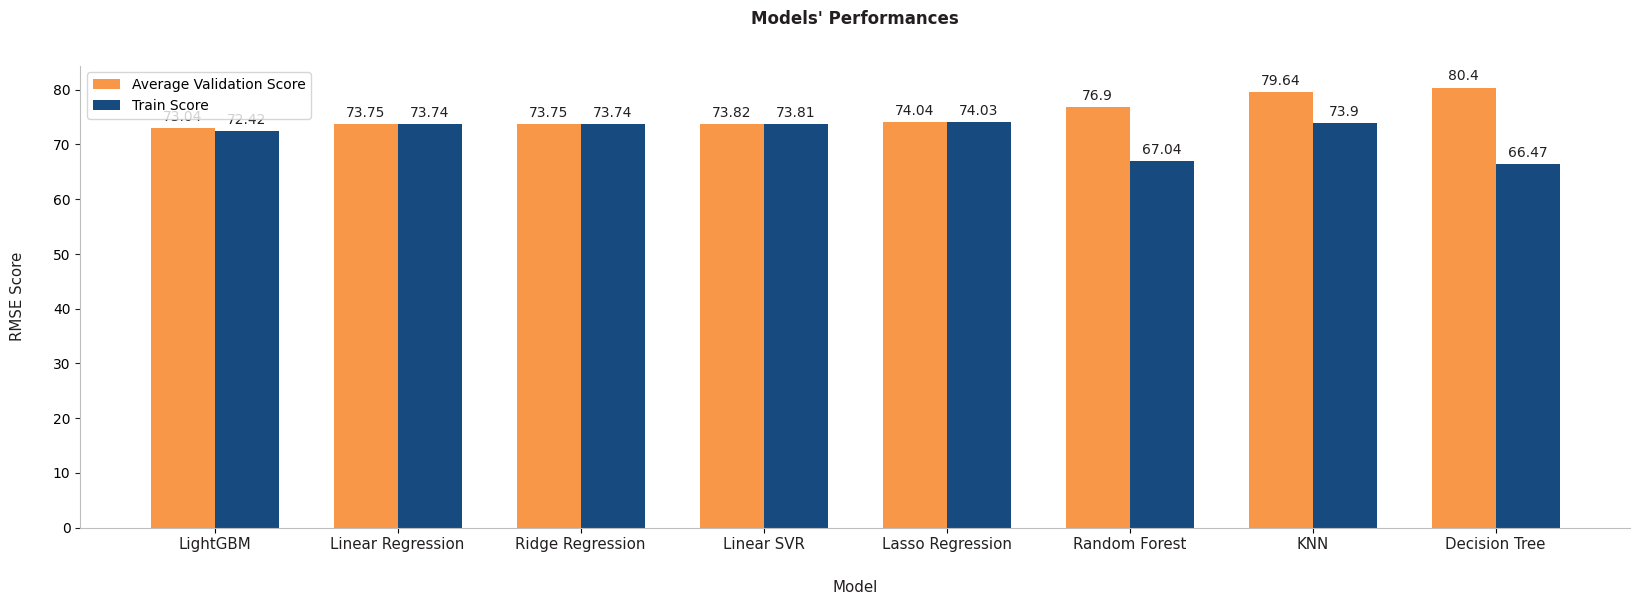

In [20]:
eval_df = evaluate_models_cv(models=models, 
                             X_train=X_train_sample_prep, 
                             y_train=y_train_sample, 
                             n_folds=5)
eval_df

- Machine learning é sim uma solução adequada para o problema, o nosso baseline Dummy Regressor foi batido.
- Apesar de o melhor modelo ter sido o LightGBM, modelos no top 5 apresentam uma diferença menor que 0.1 em seus RMSE scores em relação a ele.
- A Regressão Lasso é uma versão regularizada da Regressão Linear, que adiciona à função de custo um termo de regularização que utiliza a norma L1 do vetor de pesos das características. Além disso, esse modelo é capaz de realizar uma seleção de variáveis "automática" durante o treinamento.
- Eu escolherei a Regressão Lasso para proceder para a tunagem de hiperparâmetros e avaliação final. Motivos:
    - Eu suspeito que algumas características como a língua escolhida pelo candidato possam ser irrelevantes e confundam o modelo. A Regressão Lasso possui a propriedade de selecionar automaticamente variáveis importantes durante o treinamento, atribuindo a variáveis irrelevantes peso zero, gerando um modelo esparso.
    - A Regressão Lasso ajudará a prevenir o overfitting.
    - A Regressão Lasso possibilita um custo benefício maior, dado a sua rapidez no treinamento, maior interpretabilidade (coeficientes fornecidos) e menor custo de deploy / implantação.
    - Foi observado durante a eda uma relação linear entre as diferentes categorias das variáveis e o target, como mencionado no tópico anterior. É provável que o fenômeno seja explicado por essa simples relação e obtenhamos estimativas coeficientes confiáveis.


#### 6. Tunagem de hiperparâmetros
- Irei tunar os hiperparâmetros da Regressão Lasso utilizando a otimização bayesiana através da biblioteca optuna.
- A otimização bayesiana realiza buscas inteligentes no espaço de hiperparâmetros do modelo, balanceando o trade-off exploration-exploitation.
- O grid search é ineficiente pois realiza uma busca exaustiva, testando todas as combinações de parâmetros possíveis e não considerando efeitos da interação entre parâmetros. Isso seria ruim no nosso caso, pois o conjunto de dados de treinamento é extenso e parâmetros como a tolerância estão relacionados a outros.
- Em cada iteração, treinaremos o modelo com os parâmetros no conjunto de treinamento e avaliaremos no conjunto de validação, para evitar o overfit decorrente do ajuste excessivo de hiperparâmetros no conjunto de treinamento.

In [100]:
def objective(trial):
    # Define the hyperparameter search space.
    params = {
        'alpha': trial.suggest_float('alpha', 0.5, 3.0, step=0.5),
        'precompute': trial.suggest_categorical('precompute', [True, False]),
        'max_iter': trial.suggest_int('max_iter', 1000, 3000, step=500),
        'tol': trial.suggest_float('tol', 1e-5, 1e-1),
        'warm_start': trial.suggest_categorical('warm_start', [True, False]),
        'selection': trial.suggest_categorical('selection', ['cyclic', 'random'])
    }

    # Train the Lasso regression model with the sampled hyperparameters.
    model = Lasso(**params)
    model.fit(X_train_prepared, y_train)

    # Make predictions on the validation set.
    y_pred = model.predict(X_val_prepared)

    # Calculate the root mean squared error.
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2023-12-28 13:08:16,170] A new study created in memory with name: no-name-4489dbeb-6a4c-4ef7-98cf-4ef711d0b313


[I 2023-12-28 13:08:18,030] Trial 0 finished with value: 73.93117895929196 and parameters: {'alpha': 0.5, 'precompute': False, 'max_iter': 1000, 'tol': 0.0454161471892414, 'warm_start': False, 'selection': 'cyclic'}. Best is trial 0 with value: 73.93117895929196.
[I 2023-12-28 13:08:18,680] Trial 1 finished with value: 74.33331417438023 and parameters: {'alpha': 1.5, 'precompute': True, 'max_iter': 1500, 'tol': 0.05328092524747543, 'warm_start': True, 'selection': 'random'}. Best is trial 0 with value: 73.93117895929196.
[I 2023-12-28 13:08:19,240] Trial 2 finished with value: 74.32933004312255 and parameters: {'alpha': 1.5, 'precompute': True, 'max_iter': 1000, 'tol': 0.09817931433213625, 'warm_start': True, 'selection': 'random'}. Best is trial 0 with value: 73.93117895929196.
[I 2023-12-28 13:08:20,383] Trial 3 finished with value: 74.62094002738179 and parameters: {'alpha': 2.5, 'precompute': False, 'max_iter': 3000, 'tol': 0.031861932456685185, 'warm_start': False, 'selection': 'r

Best Hyperparameters: {'alpha': 0.5, 'precompute': True, 'max_iter': 1000, 'tol': 0.06959664902680052, 'warm_start': True, 'selection': 'cyclic'}


#### 7. Avaliação do modelo final
- Avaliarei a performance to modelo final tunado no conjunto de testes (dados nunca vistos antes pelo modelo, simulando o ambiente de produção).
- Para avaliá-lo, serão analisadas algumas métricas, como o RMSE, MSE, MAE, MAPE e R2.
- Após avaliar o modelo, eu irei interpretar os seus resultados. Particularmente, em se tratando de uma Regressão Lasso, analisaremos seus coeficientes e obteremos insights sobre quais os fatores mais e menos determinantes na nota geral do candidato.

- Treinando o modelo final em todo o conjunto (treino + validação), com os melhores parâmetros encontrados na busca bayesiana e efetuando as predições.

In [21]:
# Obtaining best model with best parameters found in bayesian optimization.
#best_params = {'alpha': 0.5, 'precompute': True, 'max_iter': 1000, 'tol': 0.06959664902680052, 'warm_start': True, 'selection': 'cyclic'}
#lasso_reg = Lasso(**best_params)

lgb = LGBMRegressor(verbose=-1)
# Obtaining training + validation predictor and target sets.
X_train_prep_full = pd.concat([X_train_prep_df, X_val_prep_df])
y_train_full = pd.concat([y_train, y_val])

# Fitting the model to the training data and predicting.
lgb.fit(X_train_prep_full, y_train_full)
y_pred = lgb.predict(X_test_prep_df)

- Observando alguns valores reais e preditos para a nota geral.

In [74]:
actual_pred_df = compare_actual_predicted(y_test, y_pred)
actual_pred_df.sample(15)

,Actual,Predicted,Residual
1923067,596.559998,568.30,28.26
707222,514.799988,478.01,36.79
286012,535.179993,568.25,33.07
2089266,646.840027,554.67,92.17
490817,723.400024,630.53,92.87
1771153,635.739990,644.88,9.14
2012599,465.480011,531.26,65.78
1571865,510.359985,592.63,82.27
1652903,539.039978,555.02,15.98
1071720,556.000000,580.62,24.62


- É possível perceber que o modelo tende a errar mais em casos mais extremos, como notas abaixo da média (valores como 300) e notas acima da média (valores como 700). No geral, considerando as variáveis que tínhamos, o resultado parece satisfatório.

- Métricas de regressão.

Mean Absolute Error (MAE): 56.4959
Mean Absolute Percentage Error (MAPE): 10.9787
Mean Squared Error (MSE): 5190.9439
Root Mean Squared Error (RMSE): 72.0482
R-Squared (R2): 0.3277


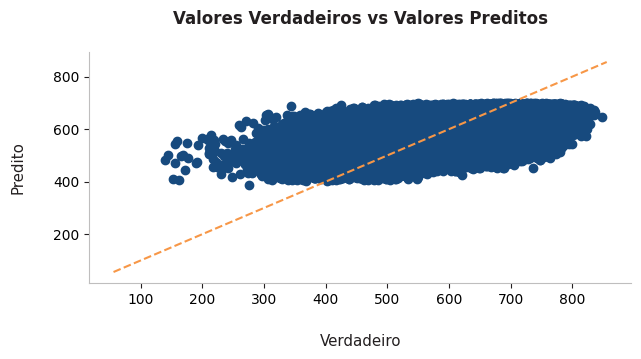

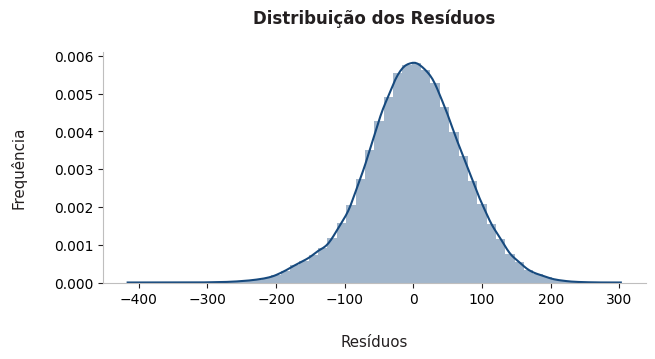

In [22]:
df_results = evaluate_regressor(y_test, y_pred, y_train_full, 'Linear')

In [23]:
df_results

,Model,MAE,MAPE,RMSE,R2
Results,Linear,56.4959,10.9787,72.0482,0.3277


In [25]:
print(f'Valor mínimo predito = {round(y_pred.min(), 2):.2f}  |  Valor mínimo real = {round(y_test.min(), 2):.2f}')
print(f'Valor máximo predito = {round(y_pred.max(), 2):.2f}  |  Valor máximo real = {round(y_test.max(), 2):.2f}')

Valor mínimo predito = 389.40  |  Valor mínimo real = 140.18
Valor máximo predito = 700.46  |  Valor máximo real = 848.32


- Nosso modelo de Regressão Lasso final apresenta uma performance satisfatória:
    - MAE (Erro Absoluto Médio): O MAE de 58.2 indica que, em média, as previsões do modelo estão desviadas por 58.2 pontos em relação às notas reais dos alunos no enem.
    - MAPE (Erro Percentual Absoluto Médio): O MAPE de 11.3097% sugere que, em média, as previsões do modelo têm um desvio percentual absoluto de 11.3097% em relação às notas reais dos alunos no enem.
    - RMSE (Raiz do Erro Quadrático Médio): O RMSE de 74.0303 indica que, em média, as previsões do modelo têm um desvio de 74.0303 pontos em relação às notas reais dos alunos no ENEM, considerando a penalização dos erros quadráticos.
    - R2: O R2 de 0.29 indica que aproximadamente 29% da variabilidade nas notas dos alunos no enem é explicada pelo modelo de regressão.  Isso sugere uma explicação limitada da variação nas notas, indicando que o modelo pode não capturar totalmente os padrões presentes nos dados.
    - É possível perceber que o modelo tem maior dificuldade em prever outliers, como notas muito acima da média e notas muito abaixo dela. Por exemplo, o valor predito mínimo é de 373, enquanto o valor real mínimo é de 140. Além disso, o valor predito máximo é de 673, enquanto o valor real máximo é de 848. Isso ocorre porque esses valores são raros, havendo uma enorme concentração em torno da média, como foi possível observar na eda. A distribuição das notas gerais é quase normal, exceto por uma ligeira cauda à esquerda contendo essas notas baixíssimas.
    - A observação acima é reforçada analisando-se a distribuição dos resíduos. Os resíduos possuem média zero e estão quase normalmente distribuídos, exceto por uma cauda maior à esquerda. Essa cauda indica que o modelo tende a prever valores maiores para notas reais menores. Essa é uma das suposições da regressão linear, e não está sendo fielmente atendida. Entretanto, para fins de predição, mesmo não atendendo-a, este modelo é útil.
        - Para contornar isso e melhorar o modelo, seria interessante realizar uma feature engineering focada nessas observações com valores maiores ou menores de nota. Além disso, incluir variáveis com maior poder preditivo também seria de ótimo proveito.
        - Não é interessante remover esses outliers, afinal, na realidade haverá alunos que não se capacitaram e tirarão notas baixíssimas e alunos que estudaram muito, gabaritando as provas e obtendo um desempenho altíssimo.
- Considerando uma nota média de todos os alunos no ENEM de 543, essas métricas indicam que o modelo tem algum poder preditivo, mas há espaço para melhorias, pois os erros médios e percentuais ainda são significativos.

- Vamos comparar o RMSE do modelo nas amostras de treino, teste e validação, a fim de se certificar que o modelo não está com overfit.

In [25]:
# Predicting on train, test and validation sets.
y_pred_train = lasso_reg.predict(X_train_prep_df)
y_pred_val = lasso_reg.predict(X_val_prep_df)
y_pred_test = y_pred

# Obtaining RMSE on each of these sets.
rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 2)
rmse_test = round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2)
rmse_val = round(np.sqrt(mean_squared_error(y_val, y_pred_val)), 2)

# Output a dataframe for better visualization.
train_test_val_rmse = pd.DataFrame({'RMSE': [rmse_train, rmse_val, rmse_test]}, index=['Train', 'Test', 'Val'])
train_test_val_rmse

,RMSE
Train,74.16
Test,73.93
Val,74.03


- Como podemos ver, os scores nas amostras de treino, teste e validação são praticamente os mesmos. Portanto, o modelo não está com overfit.

- Interpretação dos coeficientes / resultado do modelo:
    - Os coeficientes da Regresão Lasso representam a relação linear entre as variáveis independentes (renda, escolaridade do pai, entre outros) e a variável dependente (nota geral do aluno no enem), ajustada pelo termo de regularização.
    - Quanto maior o valor absoluto de um coeficiente, mais forte é o efeito da variável correspondente na variável dependente.
    - O sinal de um coeficiente indica a direção do efeito:
        - Positivo, correlação positiva.
        - Negativo, correlação negativa.
    - Coeficientes que são zero indicam que as variáveis correspondentes não são relevantes para o modelo, e eles são eliminados pela penalidade de lasso.
    - Para aqueles que não são zero, a interpretação é: "A cada mudança de uma unidade na variável preditora, há uma mudança de {coeficiente} unidades na variável resposta, mantendo todas as outras variáveis constantes".

In [155]:
cols.append('intercepto')
coefficients = lasso_reg.coef_.tolist() 
coefficients.append(lasso_reg.intercept_)
coef_df = linear_interpretation_df(cols, coefficients)
coef_df

,Coeficiente,Correlação
Variável,,
intercepto,502.686606,Positiva
possui_computador_em_casa,21.789867,Positiva
lingua,21.407289,Positiva
renda_familiar_mensal,20.511048,Positiva
status_conclusao_ensino_medio,18.309487,Positiva
escolaridade_mae,8.626941,Positiva
faixa_etaria,-7.388275,Negativa
norte,-6.734514,Negativa
escolaridade_pai,5.795471,Positiva


- O intercepto é de 512.88. Isso significa que, caso não saibamos nenhuma das informações das variáveis, o modelo prevê uma nota dessa magnitude.
- As variáveis irrelevantes, que tiveram seus coeficientes reduzidos a zero são sexo e sul. Isso faz total sentido. Foi visto na eda que a nota geral não apresentava nenhuma distinção por sexo, por exemplo. Ademais, variáveis como treineiro possuem baixa influência na nota do candidato.
- As 5 variáveis mais importantes são: 
    - possui_computador_em_casa, renda_familiar_mensal, status_conclusao_ensino_medio, escolaridade_mae e norte.
    - Isso faz sentido, uma vez que vimos na eda que:
        - Alunos que não possuíam computador em casa apresentavam desempenho consideravelmente menor.
        - Quanto maior a renda familiar mensal e a escolaridade do responsável, maior a nota do candidato.
        - Estados da região norte apresentavam as piores notas no enem.
    - Dessas, as primeiras quatro apresentam uma correlação positiva. Uma vez que foram codificadas em relação ordinal, fica fácil a interpretação. Por exemplo:
        - O aumento de uma unidade em possui_computador_em_casa, ou seja, de nenhum para um, ou de um para dois ou mais, reflete um aumento de 23.36 na nota geral, considerando todas as outras variáveis constantes.
    - A variável norte apresenta uma correlação negativa. Uma vez que esta representa uma variável dummy, indicando 1 caso o candidato seja dessa região, ou 0, caso não, a interpretação pode ser feita da seguinte forma:
        - Caso o estudante seja da região norte, a sua nota reduz em 8.85 pontos, considerando todas as outras variáveis constantes.

#### 8. Conclusão

- Neste notebook, foi desenvolvido um modelo preditivo de Regressão Lasso para predição da nota geral do candidato no enem. 
- Foram consideradas diversas variáveis na construção do modelo. Os insights obtidos na etapa de análise exploratória de dados serviram de guia para tarefas de limpeza e pré-processamento de dados, necessárias para a aplicação de algoritmos de machine learning.
- Após a limpeza, avaliamos através da validação cruzada k-fold modelos potenciais, a fim de selecionar um deles para a tunagem de hiperparâmetros e avaliação final no conjunto de testes, simulando o ambiente de produção. O modelo selecionada foi a Regressão Lasso pois eu suspeitava de variáveis que não teriam importância, confundindo o modelo, e desejava realizar uma seleção automática delas. Além disso, a regularização aplicada ajudou a prevenir o overfitting. E de fato, o modelo apresentou scores similares nas amostras de treino, teste e validação.
- O resultado obtido foi satisfatório, porém há espaço para melhorias:
    - Com um MAE de aproximadamente 58, as previsões do modelo são desviadas, em média, de 58 pontos em relação às notas reais dos candidatos no enem.
    - Com um R2 de 0.29, aproximadamente 29% da variância do target é explicada pelo modelo / variáveis independentes. 
    - Foi observado que o modelo tende a errar mais para valores extremos, como notas baixíssimas próximas a 100 e notas altíssimas na casa dos 800 pontos. Isso ocorre porque a grande massa de notas tende a se concentrar em torno do valor médio, na casa do 500-600 pontos. Talvez uma feature engineering focada nessas notas maiores e menores e/ou a introdução de variáveis com potencial preditivo maior melhorasse esse aspecto. Isso será testado no futuro.
- Os coeficientes foram interpretados e, como eu suspeitava, algumas variáveis eram irrelevantes, ficando com coeficiente 0. Além disso, as 5 variáveis mais importantes foram:
    - possui_computador_em_casa, renda_familiar_mensal, status_conclusao_ensino_medio, escolaridade_mae e norte.
    - Isso faz sentido, uma vez que vimos na eda que:
        - Alunos que não possuíam computador em casa apresentavam desempenho consideravelmente menor.
        - Quanto maior a renda familiar mensal e a escolaridade do responsável, maior a nota do candidato.
        - Estados da região norte apresentavam as piores notas no enem.
- A sua interpretação encontra-se no notebook. Foi possível observar que, por exemplo, o aumento de uma unidade em possui_computador_em_casa, ou seja, de nenhum para um, ou de um para dois ou mais, reflete um aumento de 23.36 na nota geral, considerando todas as outras variáveis constantes.
- Para os próximos passos, estão o deploy do modelo em produção.